In [30]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import astropy
import GCRCatalogs as gcr
import astropy.units as u
from astropy import cosmology
# import astropy.cosmology.units as cu
from astropy.cosmology import z_at_value
import scipy.stats as stats

from astropy.table import Table
import matplotlib.cm as cm
plt.style.use('MNRAS.mplstyle')

In [31]:
redmapper = gcr.load_catalog('skysim5000_v1.1.1_redmapper_v0.8.5')
redmapper_cl = Table(redmapper.get_quantities(['redshift','clusters/mem_match_id','richness','clusters/cg_spec_z','clusters/z_lambda'])) #46491
print(len(redmapper_cl))
redmapper_me = Table(redmapper.get_quantities(['members/z','members/mem_match_id','members/zspec','members/mag/1', 'p_member'])) #2381320
print(len(redmapper_me))

46491
2381320


In [32]:
# data = Table(redmapper_cl[1].read())
z_BCG = redmapper_cl['clusters/cg_spec_z'] 
z_lambda = redmapper_cl['clusters/z_lambda']
Lambda = redmapper_cl['richness'] 
sel = (z_BCG != -1) & (0.8 <= z_lambda) & (z_lambda < 1)
ID_cl = redmapper_cl['clusters/mem_match_id'][sel] 
z_BCG = z_BCG[sel]
z_lambda = z_lambda[sel]
Lambda = Lambda[sel]


z_mem = redmapper_me['members/zspec']
sel = (z_mem != -1)
z_mem = z_mem[sel]
ID_mem = redmapper_me['members/mem_match_id'][sel]

mag_i = redmapper_me['members/mag/1'][sel]

#applying the Lstar filter
exp = (mag_i - 22.44-3.36*np.log10(z_mem)-0.273*np.log10(z_mem)**2+0.0618*np.log10(z_mem)**3+0.0227*np.log10(z_mem)**4) / -2.5
lstar_frac = 10**exp
sel = (lstar_frac >= 0.55)
z_mem = z_mem[sel]
ID_mem = ID_mem[sel]

#filtering out galaxies that don't belong to clusters with z_BCG
sel = np.isin(ID_mem, ID_cl)
ID_mem = ID_mem[sel]
z_mem = z_mem[sel]

delz = np.array([])
delzov1pz = np.array([])

#calculating delta z for each member
for i in range(len(ID_cl)):
    sel = (ID_mem == ID_cl[i])
    delz = np.concatenate((delz, z_mem[sel] - z_BCG[i]))
    delzov1pz = np.concatenate((delzov1pz, (z_mem[sel] - z_BCG[i]) / (1 + z_BCG[i])))  
    
H0 = 71 #km/s/Mpc
H0_astropy = 71 * u.km/u.s/u.Mpc
Om = 0.265

## Andy's Method

In [34]:
# this function converts a velocity (v) to a redshift space distortion (dzov1pz) using the provided cosmological parameters 

cosmo = astropy.cosmology.FlatLambdaCDM(H0=H0, Om0=Om)

def velocity_to_dzov1pz(z, v):
    v_ref = H0_astropy * (cosmo.comoving_distance(z) / (1+z)) 

    chi = ((v_ref + v*u.km/u.s)/H0_astropy)*(1+z)
    
    dzpz = z_at_value(cosmo.comoving_distance, chi)
    
    return (dzpz-z)/(1+z)

In [6]:
### 0.2<=z<0.8
from matplotlib.ticker import MaxNLocator, LogLocator

myles_bin_edges = np.array([20,30,45,60,500]) #richness bins
myles_mean_bin_richness = np.array([9.11618, 23.4515,  31.8795,  42.2766,  57.9498,  84.7792])

myles_sigma_cl = np.array([379, 503, 614, 634])  ##np.array([379, 503, 614, 634]) #km/s
myles_f_proj = np.array([0.392, 0.265, 0.243, 0.251])

sigma_proj =  4000 #8689 #km/s
mu_proj = 100 #1299 #km/s

mean_bin_richness = []
bf_f_proj = np.zeros(len(myles_bin_edges) - 1)
bf_sigma_cl = np.zeros(np.shape(bf_f_proj))
bf_mu_proj = np.zeros(np.shape(bf_f_proj))
bf_sigma_proj = np.zeros(np.shape(bf_f_proj))

def dbl_gauss(delz, f_proj, sigma_cl, mu_proj, sigma_proj):
    return (1 - f_proj) * norm.pdf(delz, loc=0, scale=sigma_cl) + f_proj * norm.pdf(delz, loc=mu_proj, scale=sigma_proj)

def dbl_gauss_cdf(delz, f_proj, sigma_cl, mu_proj, sigma_proj):
    return (1 - f_proj) * norm.cdf(delz, loc=0, scale=sigma_cl) + f_proj * norm.cdf(delz, loc=0, scale=0.000001)  # loc=-0.0001, scale=0.000001
 
bf_f_proj = np.zeros(len(myles_bin_edges) - 1)
bf_sigma_cl = np.zeros(np.shape(bf_f_proj))
bf_mu_proj = np.zeros(np.shape(bf_f_proj))
bf_sigma_proj = np.zeros(np.shape(bf_f_proj))

fig, axs = plt.subplots(4, 2, figsize=(8, 12),sharex=True)

for i in range(len(myles_bin_edges) - 1):
    # Selecting halos in current richness bin
    if i != 0:
        sel = (myles_bin_edges[i] < Lambda) & (Lambda <= myles_bin_edges[i+1])
        legend = f'{myles_bin_edges[i]} < λ ≤ {myles_bin_edges[i+1]}'
    else:
        sel = (myles_bin_edges[i] <= Lambda) & (Lambda <= myles_bin_edges[i+1])
        legend = f'{myles_bin_edges[i]} ≤ λ ≤ {myles_bin_edges[i+1]}'

    mean_z = np.mean(z_BCG[sel])  # Needed for converting from redshift to km/s
    sel_ID_cl = ID_cl[sel]  # Getting ID's to select corresponding members

    mean_bin_richness.append(np.mean(Lambda[sel]))  # Getting mean richness for x-axis on plots

    # Selecting members that correspond to halos
    sel = np.isin(ID_mem, sel_ID_cl)
    delzov1pz_sel = delzov1pz[sel]

    # Sorting delta z to make CDF
    sel = np.argsort(delzov1pz_sel)
    delzov1pz_sel = delzov1pz_sel[sel]    
    # print(len(delzov1pz_sel), np.min(delzov1pz_sel), np.max(delzov1pz_sel))

    cdf = (np.arange(len(delzov1pz_sel)) + 1.0) / len(delzov1pz_sel)

    bf_params = curve_fit(dbl_gauss_cdf, delzov1pz_sel, cdf, p0=[myles_f_proj[i],velocity_to_dzov1pz(mean_z, myles_sigma_cl[i]),
                                                                 velocity_to_dzov1pz(mean_z, mu_proj), velocity_to_dzov1pz(mean_z, sigma_proj)],
                         maxfev = 10000000)[0]
    print(bf_params)
    if (bf_params[1] < bf_params[3]):

        bf_f_proj[i] = bf_params[0]
        bf_sigma_cl[i] = bf_params[1]
        bf_sigma_proj[i] = bf_params[3]
    else:
        bf_f_proj[i] = 1 - bf_params[0]
        bf_sigma_cl[i] = bf_params[3]
        bf_sigma_proj[i] = bf_params[1]
    # print(bf_params)
    delz_input = np.linspace(-0.11, 0.11, 1000)

    axs[i, 0].hist(delzov1pz_sel, bins=555, density=True, label=legend, alpha=0.5)
    # axs[i, 0].plot(delz_input, dbl_gauss(delz_input, myles_f_proj[i], velocity_to_dzov1pz(mean_z, myles_sigma_cl[i]), velocity_to_dzov1pz(mean_z, mu_proj), velocity_to_dzov1pz(mean_z, sigma_proj))) #, label='myles'
    axs[i, 0].plot(delz_input, dbl_gauss(delz_input, bf_params[0], bf_params[1], bf_params[2], bf_params[3])) #, label='best fit'
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim([1e-1, 1e3])
    axs[i, 0].set_ylabel('PDF')
    axs[i, 0].grid(visible=False)

    axs[i, 1].plot(delzov1pz_sel, cdf, label='data')
    # axs[i, 1].plot(delz_input, dbl_gauss_cdf(delz_input, bf_f_proj[i], velocity_to_dzov1pz(mean_z, myles_sigma_cl[i]), velocity_to_dzov1pz(mean_z, mu_proj), velocity_to_dzov1pz(mean_z, sigma_proj)), label='myles')
    axs[i, 1].plot(delz_input, dbl_gauss_cdf(delz_input, bf_params[0], bf_params[1], bf_params[2], bf_params[3]), label='best fit')
    axs[i, 1].set_xlim((-0.1, 0.1))
    axs[i, 1].set_ylabel('CDF')
    axs[i, 1].grid(visible=False)
    
    axs[i, 0].legend(loc='upper left', frameon=False,fontsize=17,
                        handletextpad=0.2, 
                        columnspacing=0.3,
                        markerscale=0.8,  # Scale down the size of the markers
                        handlelength=1)
    axs[3, 1].legend(loc='upper left', frameon=False, fontsize=17,
                        handletextpad=0.2, 
                        columnspacing=0.3,
                        markerscale=0.8,  # Scale down the size of the markers
                        handlelength=1)

 # Manually adjust the upper y-label
    y_labels = axs[i, 0].get_yticklabels()
    y_labels[-2].set_visible(False)

# Set the x and y-axis labels for the bottom subplots
for ax in axs[-1, :]:
    ax.set_xlabel('$\Delta z/(1+z)$')
    
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0.3)

plt.show()
print(bf_sigma_proj)
print(bf_sigma_cl)
print(bf_f_proj)
print(bf_mu_proj)

/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
No handles with labels found to put in legend.
/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
No handles with labels found to put in legend.
/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
No handles with labels found to put in legend.
/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings

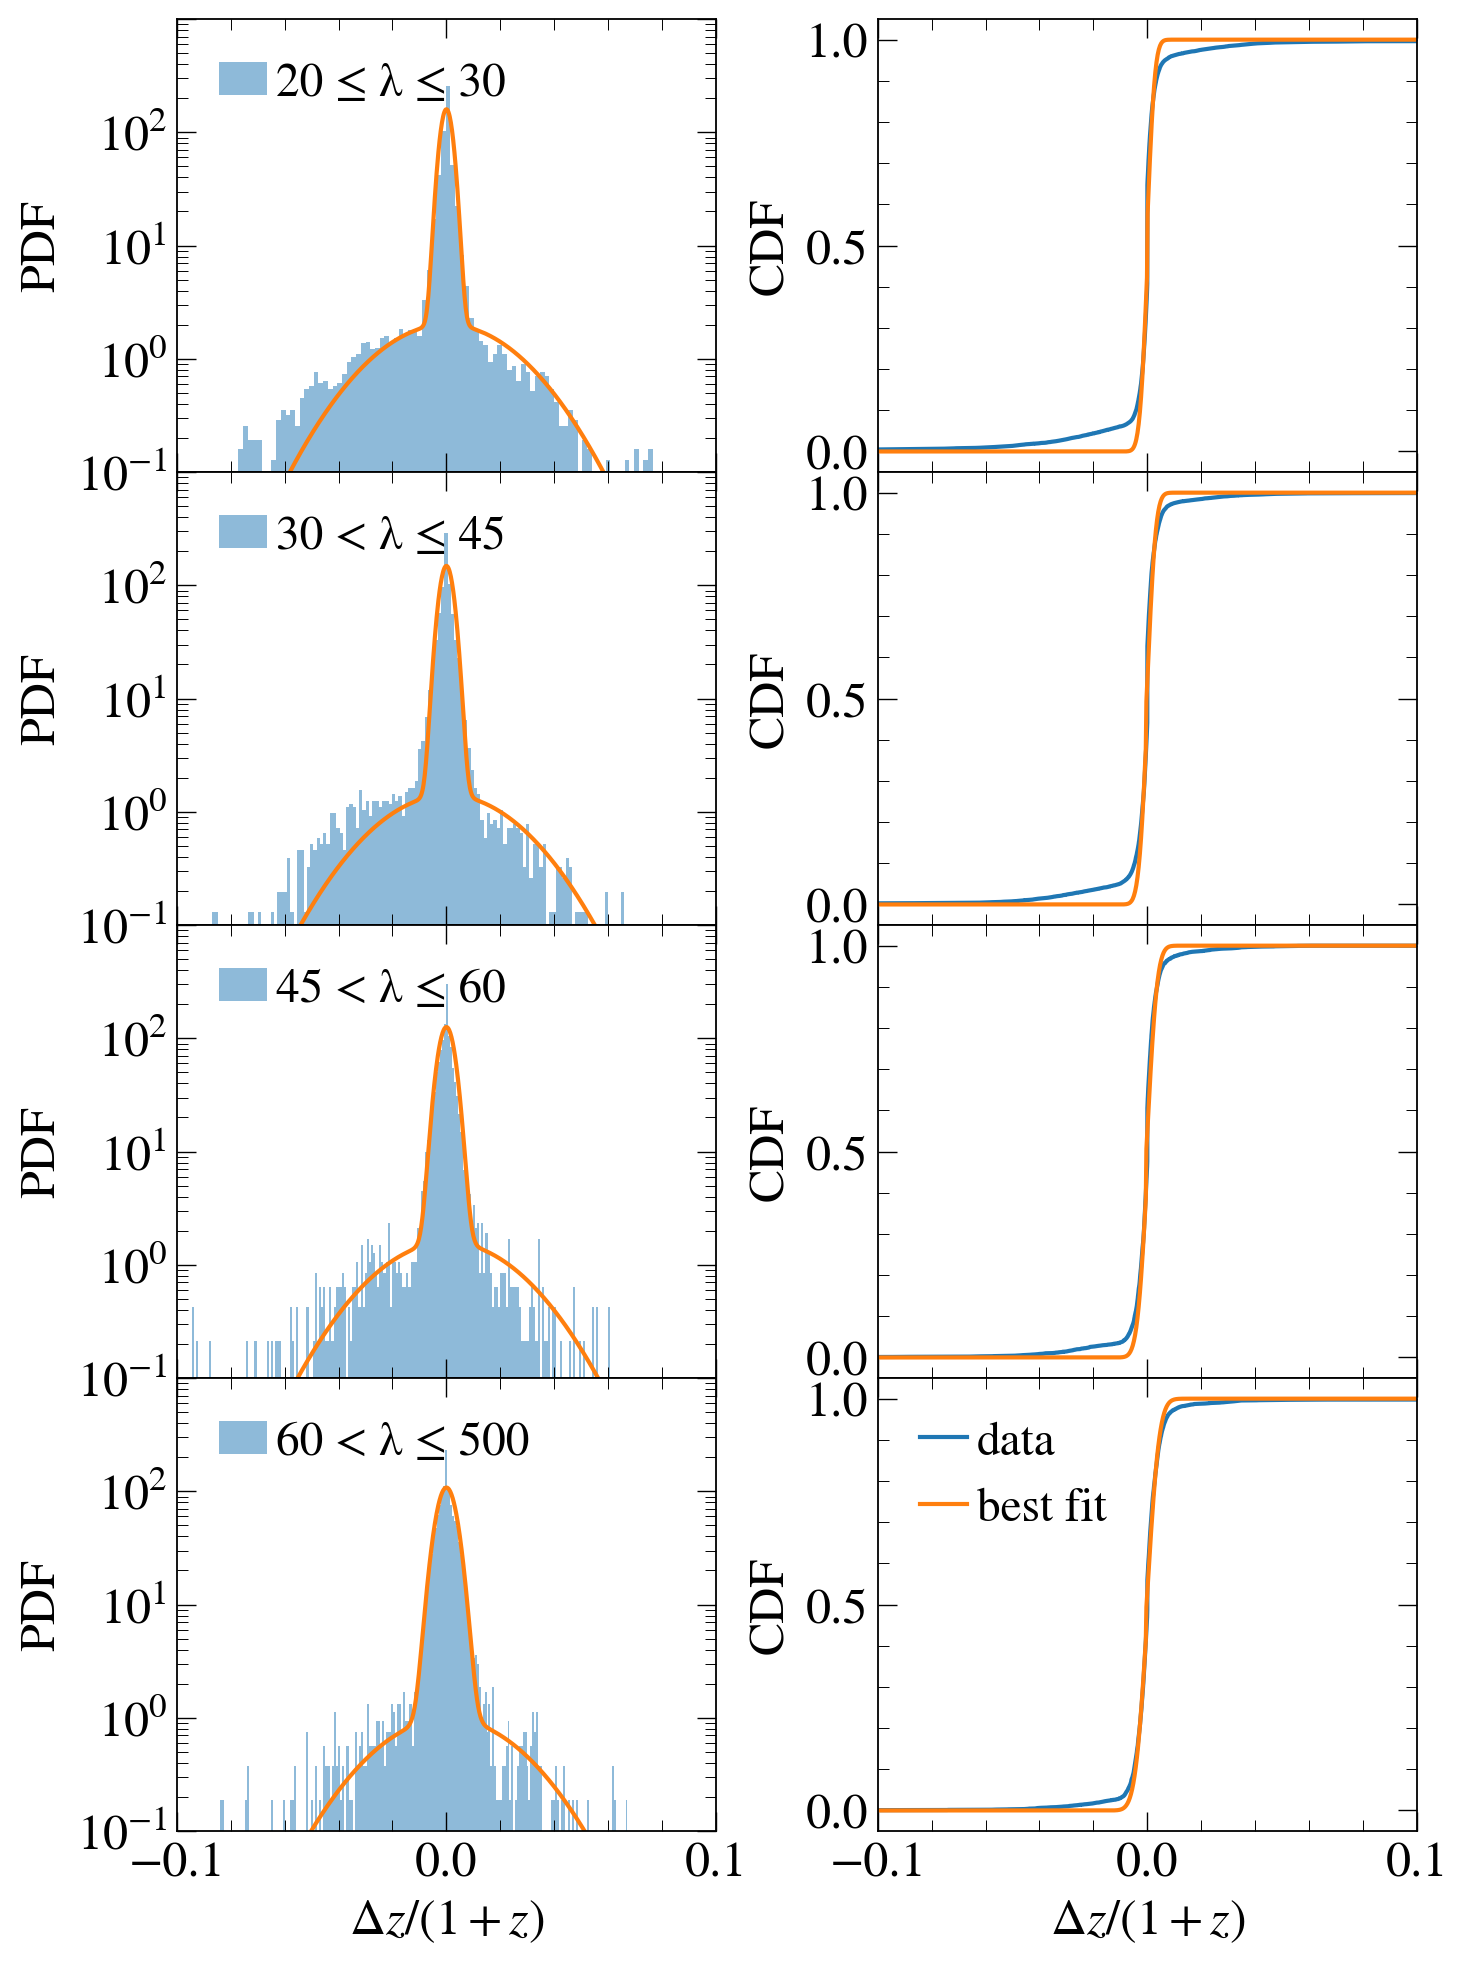

[0.02374493 0.02374906 0.02372476 0.02373626]
[0.00222591 0.00248683 0.00291215 0.00351178]
[0.11949781 0.08355442 0.09393656 0.05837905]


In [14]:
from matplotlib.ticker import MaxNLocator, LogLocator

myles_bin_edges = np.array([20,30,45,60,500]) #richness bins

myles_sigma_cl = np.array([379, 503, 614, 634, 770, 1060]) #km/s
myles_mean_bin_richness = np.array([9.11618, 23.4515,  31.8795,  42.2766,  57.9498,  84.7792])

myles_f_proj = np.array([0.392, 0.265, 0.243, 0.251, 0.137, 0.083])
# myles_b_lambda = np.array([0.157, 0.126, 0.127, 0.160, 0.078, 0.033])

sigma_proj =  4389 #8689 #km/s
mu_proj = 100 #1299 #km/s

mean_bin_richness = []

def dbl_gauss(delz, f_proj, sigma_cl, mu_proj, sigma_proj):
    return (1 - f_proj) * norm.pdf(delz, loc=0, scale=sigma_cl) + f_proj * norm.pdf(delz, loc=mu_proj, scale=sigma_proj)

def dbl_gauss_cdf(delz, f_proj, sigma_cl, mu_proj, sigma_proj):
    return (1 - f_proj) * norm.cdf(delz, loc=0, scale=sigma_cl) + f_proj * norm.cdf(delz, loc=-mu_proj, scale=0.00000011)
 
bf_f_proj = np.zeros(len(myles_bin_edges) - 1)
bf_sigma_cl = np.zeros(np.shape(bf_f_proj))
bf_mu_proj = np.zeros(np.shape(bf_f_proj))
bf_sigma_proj = np.zeros(np.shape(bf_f_proj))

fig, axs = plt.subplots(4, 2, figsize=(8, 12),sharex=True)

for i in range(len(myles_bin_edges) - 1):
    # Selecting halos in current richness bin
    if i != 0:
        sel = (myles_bin_edges[i] < Lambda) & (Lambda <= myles_bin_edges[i+1])
        legend = f'{myles_bin_edges[i]} < λ ≤ {myles_bin_edges[i+1]}'
    else:
        sel = (myles_bin_edges[i] <= Lambda) & (Lambda <= myles_bin_edges[i+1])
        legend = f'{myles_bin_edges[i]} ≤ λ ≤ {myles_bin_edges[i+1]}'

    mean_z = np.mean(z_BCG[sel])  # Needed for converting from redshift to km/s
    sel_ID_cl = ID_cl[sel]  # Getting ID's to select corresponding members

    mean_bin_richness.append(np.mean(Lambda[sel]))  # Getting mean richness for x-axis on plots

    # Selecting members that correspond to halos
    sel = np.isin(ID_mem, sel_ID_cl)
    delzov1pz_sel = delzov1pz[sel]

    # Sorting delta z to make CDF
    sel = np.argsort(delzov1pz_sel)
    delzov1pz_sel = delzov1pz_sel[sel]
    # print(len(delzov1pz_sel))

    cdf = (np.arange(len(delzov1pz_sel)) + 1.0) / len(delzov1pz_sel)

    bf_params = curve_fit(dbl_gauss_cdf, delzov1pz_sel, cdf, p0=[myles_f_proj[i],velocity_to_dzov1pz(mean_z, myles_sigma_cl[i]),
                                                                 velocity_to_dzov1pz(mean_z, mu_proj), velocity_to_dzov1pz(mean_z, sigma_proj)],
                         maxfev = 100000)[0]
    # print(bf_params)
    if (bf_params[1] < bf_params[3]):

        bf_f_proj[i] = bf_params[0]
        bf_sigma_cl[i] = bf_params[1]
        bf_sigma_proj[i] = bf_params[3]
    else:
        bf_f_proj[i] = 1 - bf_params[0]
        bf_sigma_cl[i] = bf_params[3]
        bf_sigma_proj[i] = bf_params[1]
    # print(bf_params)
    delz_input = np.linspace(-0.11, 0.11, 1000)

    axs[i, 0].hist(delzov1pz_sel, bins=555, density=True, label=legend, alpha=0.5)
    axs[i, 0].plot(delz_input, dbl_gauss(delz_input, bf_params[0], bf_params[1], bf_params[2], bf_params[3])) #, label='best fit'
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim([1e-1, 1e3])
    axs[i, 0].set_ylabel('PDF')
    axs[i, 0].set_xlim((-0.1, 0.1))
    axs[i, 0].grid(visible=False)

    axs[i, 1].plot(delzov1pz_sel, cdf, label='data') 
    axs[i, 1].plot(delz_input, dbl_gauss_cdf(delz_input, bf_params[0], bf_params[1], bf_params[2], bf_params[3]), label='best fit')
    axs[i, 1].set_xlim((-0.1, 0.1))
    axs[i, 1].set_ylabel('CDF')
    axs[i, 1].grid(visible=False)
    

    axs[i, 0].legend(loc='upper left', frameon=False,fontsize=17,
                        handletextpad=0.2, 
                        columnspacing=0.3,
                        markerscale=0.8,  # Scale down the size of the markers
                        handlelength=1)
    axs[3, 1].legend(loc='upper left', frameon=False, fontsize=17,
                        handletextpad=0.2, 
                        columnspacing=0.3,
                        markerscale=0.8,  # Scale down the size of the markers
                        handlelength=1)
 # Manually adjust the upper y-label
    y_labels = axs[i, 0].get_yticklabels()
    y_labels[-2].set_visible(False)

# Set the x and y-axis labels for the bottom subplots
for ax in axs[-1, :]:
    ax.set_xlabel('$\Delta z/(1+z)$')
    
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0.3)
filep = r'/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/'
plt.savefig(filep + 'Images/skysim_delta_z-08-1.png', facecolor='white')

plt.show()

print(bf_sigma_proj)
print(bf_sigma_cl)
print(bf_f_proj)

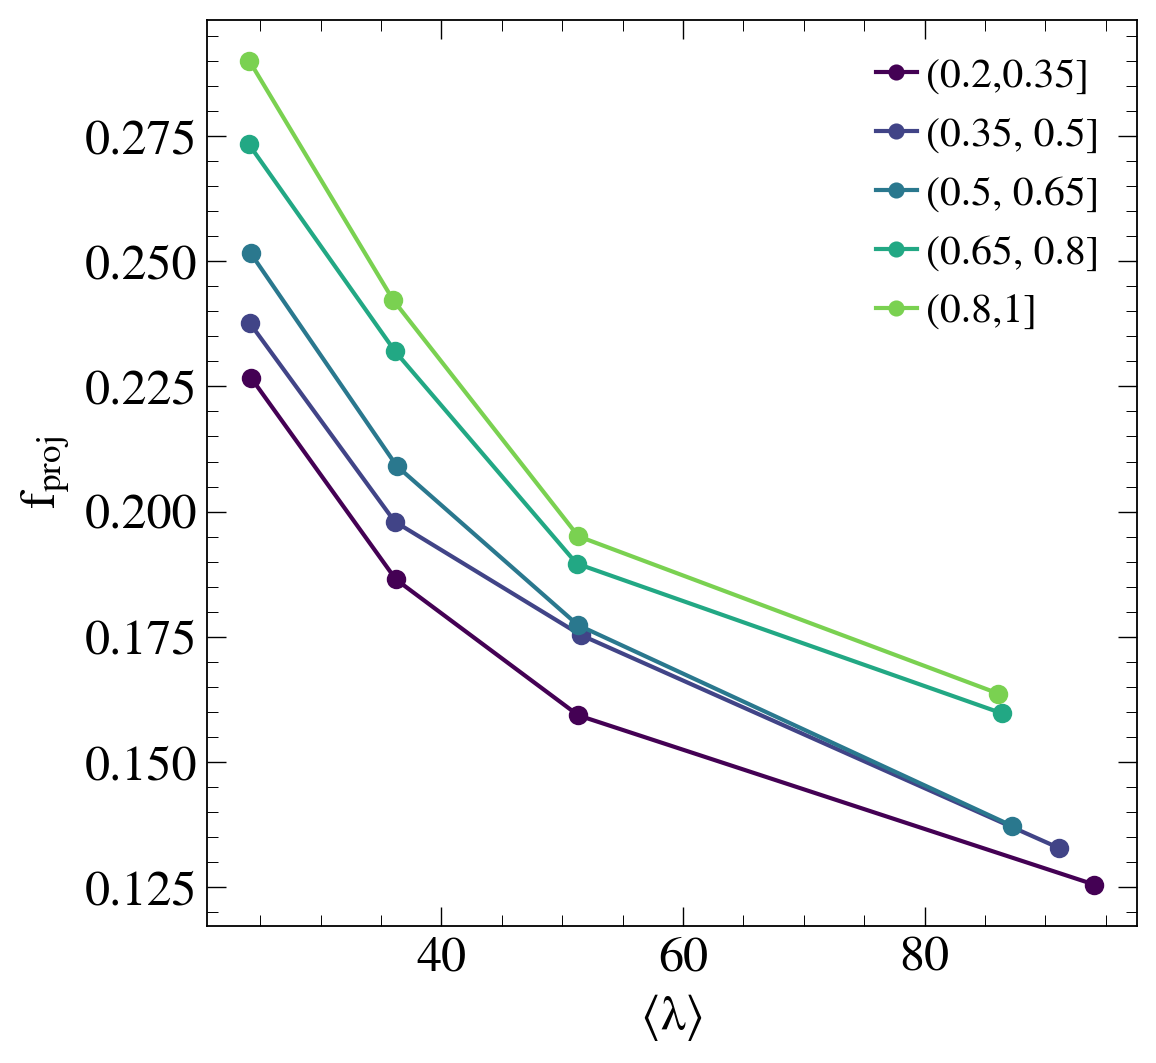

In [35]:
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]', '(0.65, 0.8]', '(0.8,1]'] #,'(0.8,1]'
mean_bin_richness = [[24.235552, 36.228844, 51.34432, 94.0438],[24.160782, 36.13709, 51.526054, 91.0869],
                     [24.218466, 36.31191, 51.293476, 87.26896],[24.063902, 36.17597, 51.195602, 86.40851],
                     [24.113165, 36.000034, 51.334446, 86.10016]]
bf_sigma_proj = [[0.0217641,  0.02176499, 0.02173106, 0.02176409], [0.02107382, 0.02106601, 0.02104893, 0.02106429], 
                 [0.02289885, 0.02288281, 0.0228611,  0.02283461], [0.02492248, 0.02494756, 0.02497037, 0.0249007],
                [0.02539016, 0.02539456, 0.02536854, 0.02538086]]
bf_sigma_cl = [[0.00191429, 0.00217393, 0.00240164, 0.00291134], [0.0018275,  0.00214604, 0.0023968,  0.00290286], 
               [0.00175341, 0.0020979,  0.00241676, 0.00287033], [0.00147009, 0.00180808, 0.00224252, 0.00268845],
              [0.00158638, 0.00188903, 0.00220425, 0.00312449]]
bf_f_proj = [[0.22678859, 0.18643908, 0.15923354, 0.12540556], [0.23762662, 0.19799012, 0.17532754, 0.13276058], 
             [0.25164459, 0.20909611, 0.1773172,  0.13711703], [0.27345167, 0.23201063, 0.18959741, 0.15964539],
            [0.2900935,  0.24234208, 0.19505503, 0.16360228]] #, [0.2900935,  0.23234208, 0.17505503, 0.11360228], , [0.32320883, 0.26038274, 0.19428354, 0.12387855]

cmap = cm.get_cmap('viridis')

names = ['z_bins','mean_bin_richness', 'bf_sigma_proj', 'bf_sigma_cl', 'bf_f_proj']

best_fit_params = Table(data = [zlabels,mean_bin_richness, bf_sigma_proj, bf_sigma_cl, bf_f_proj], names=names)

for i in range(len(best_fit_params)):
    plt.plot(mean_bin_richness[i], bf_f_proj[i], marker='o', color=cmap(i / len(best_fit_params)), label=zlabels[i])
    plt.grid(visible=False)
    plt.xlabel(r'$\rm \langle \lambda \rangle$')
    plt.ylabel(r'$\rm f_{proj}$')
plt.legend(frameon=False, fontsize=15, handletextpad=0.2, columnspacing=0.3, markerscale=0.8, handlelength=1)

filep = r'/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/'
plt.savefig(filep+'Images/skysim_fraction_projection.png', facecolor='white')
plt.show()

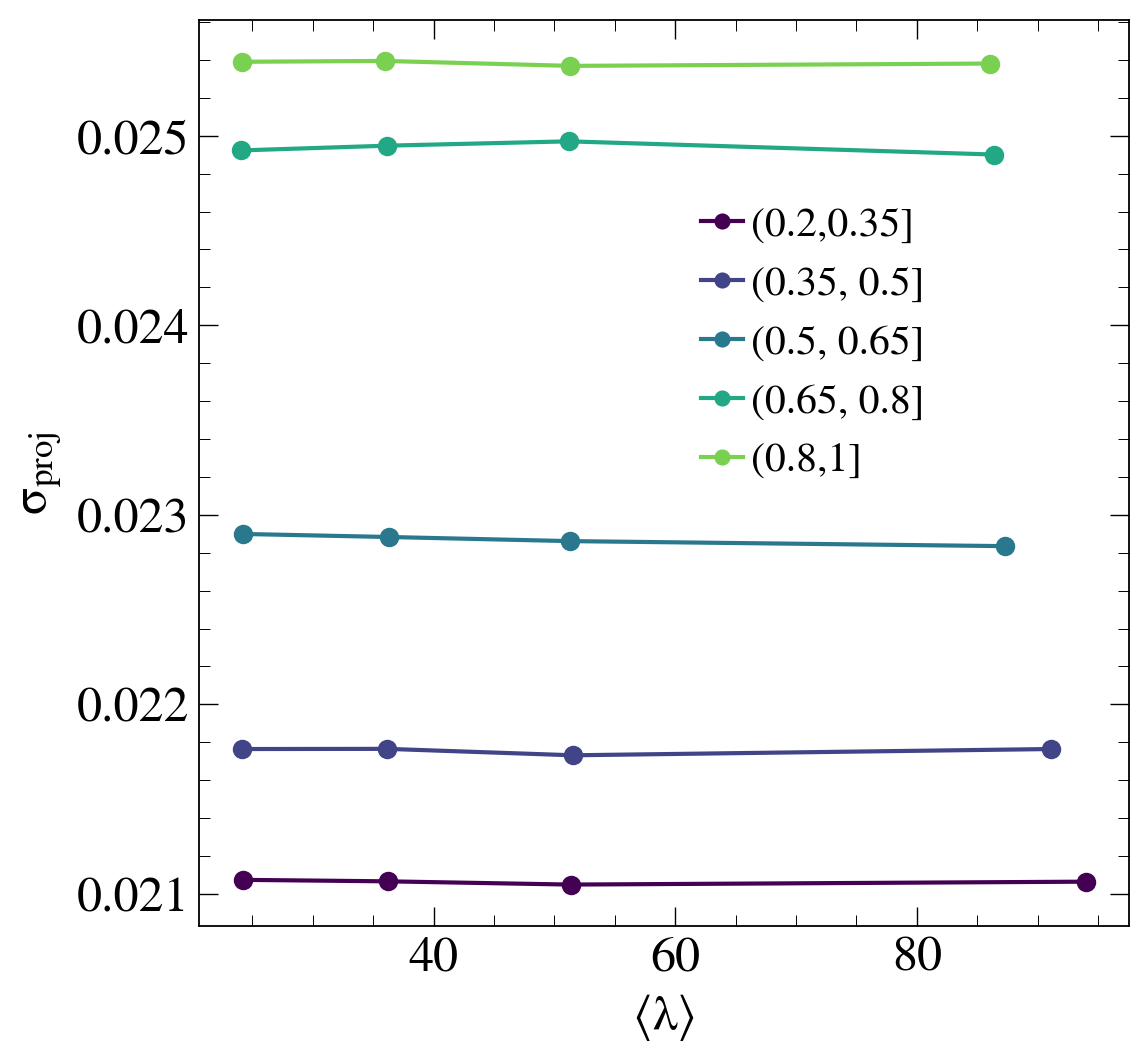

In [29]:
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]', '(0.65, 0.8]', '(0.8,1]'] #,'(0.8,1]'
mean_bin_richness = [[24.235552, 36.228844, 51.34432, 94.0438],[24.160782, 36.13709, 51.526054, 91.0869],
                     [24.218466, 36.31191, 51.293476, 87.26896],[24.063902, 36.17597, 51.195602, 86.40851],
                     [24.113165, 36.000034, 51.334446, 86.10016]]
bf_sigma_proj = [[0.02107382, 0.02106601, 0.02104893, 0.02106429], [0.0217641,  0.02176499, 0.02173106, 0.02176409],
                 [0.02289885, 0.02288281, 0.0228611,  0.02283461], [0.02492248, 0.02494756, 0.02497037, 0.0249007],
                [0.02539016, 0.02539456, 0.02536854, 0.02538086]]
bf_sigma_cl = [[0.00191429, 0.00217393, 0.00240164, 0.00291134], [0.0018275,  0.00214604, 0.0023968,  0.00290286], 
               [0.00175341, 0.0020979,  0.00241676, 0.00287033], [0.00147009, 0.00180808, 0.00224252, 0.00268845],
              [0.00158638, 0.00188903, 0.00220425, 0.00312449]]
bf_f_proj = [[0.22678859, 0.18643908, 0.15923354, 0.12540556], [0.23762662, 0.19799012, 0.17532754, 0.13276058], 
             [0.25164459, 0.20909611, 0.1773172,  0.13711703], [0.27345167, 0.23201063, 0.18959741, 0.15964539],
            [0.2900935,  0.23234208, 0.17505503, 0.11360228]] #, [0.2900935,  0.23234208, 0.17505503, 0.11360228], , [0.32320883, 0.26038274, 0.19428354, 0.12387855]

cmap = cm.get_cmap('viridis')

names = ['z_bins','mean_bin_richness', 'bf_sigma_proj', 'bf_sigma_cl', 'bf_f_proj']

best_fit_params = Table(data = [zlabels,mean_bin_richness, bf_sigma_proj, bf_sigma_cl, bf_f_proj], names=names)

for i in range(len(best_fit_params)):
    plt.plot(mean_bin_richness[i], bf_sigma_proj[i], marker='o', color=cmap(i / len(best_fit_params)), label=zlabels[i])
    plt.grid(visible=False)

    plt.xlabel(r'$\rm \langle \lambda \rangle$')
    plt.ylabel(r'$\rm \sigma_{proj}$')
plt.legend(loc='best',frameon=False, fontsize=15, handletextpad=0.2, columnspacing=0.3, markerscale=0.8,
           handlelength=1, bbox_to_anchor=(0.5, 0.45))
plt.savefig(filep+'Images/skysim_sigma_projection.png', facecolor='white')
plt.show()

4 4


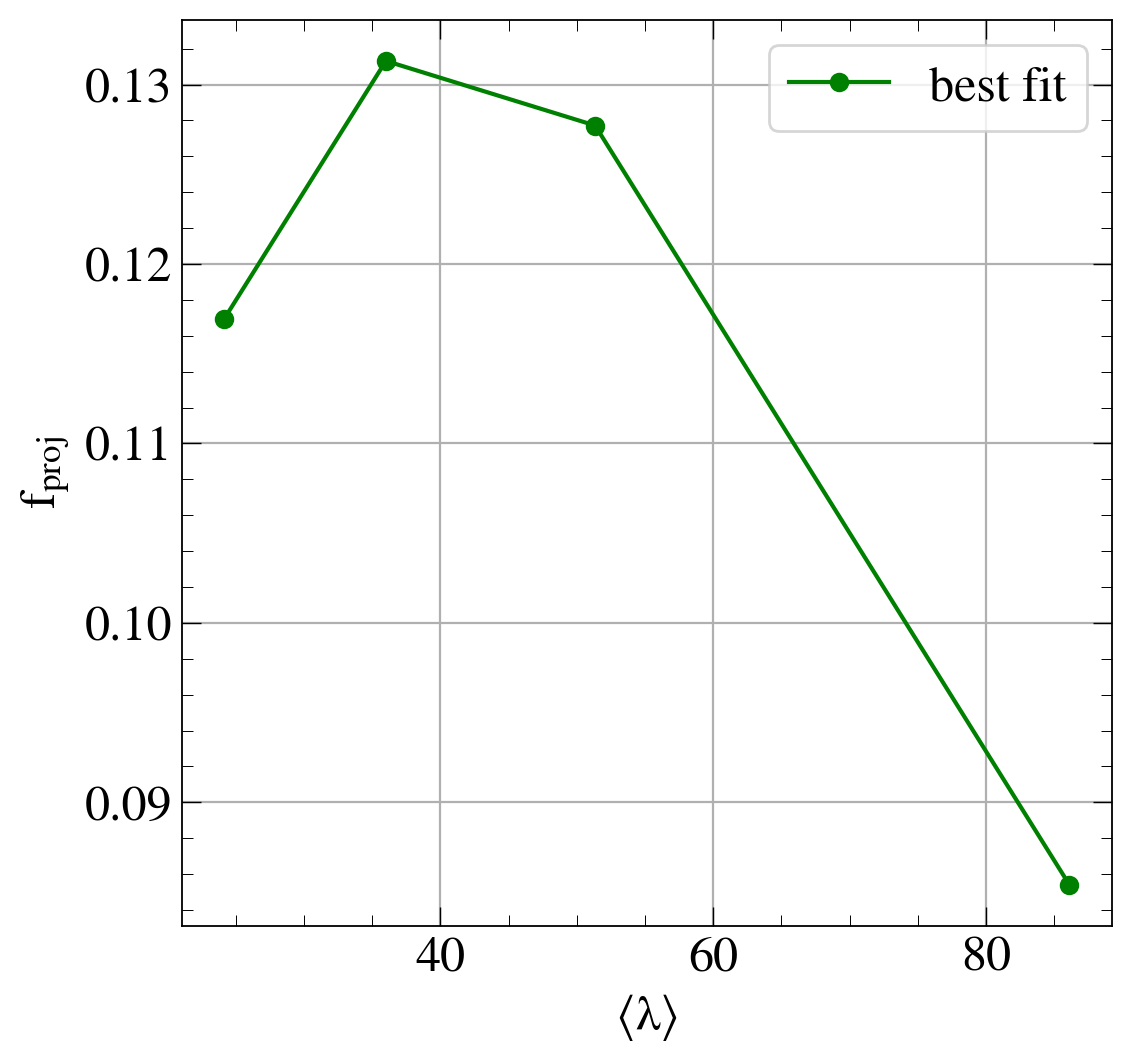

In [116]:
# plt.figure(figsize=(6,4), dpi=500)
# plt.plot(myles_mean_bin_richness, myles_f_proj, label='myles', color='orange')
print(len(mean_bin_richness),len(bf_f_proj))
plt.plot(mean_bin_richness, bf_f_proj, label='best fit', marker='o', color='green')
plt.xlabel(r'$\rm \langle \lambda \rangle$')
plt.ylabel(r'$\rm f_{proj}$')
plt.legend()
# plt.savefig('Images/fraction_projection.png', facecolor='white')
plt.show()


In [117]:
bf_sigma_proj
bf_f_proj

array([0.11690982, 0.13131728, 0.12771913, 0.08541759])

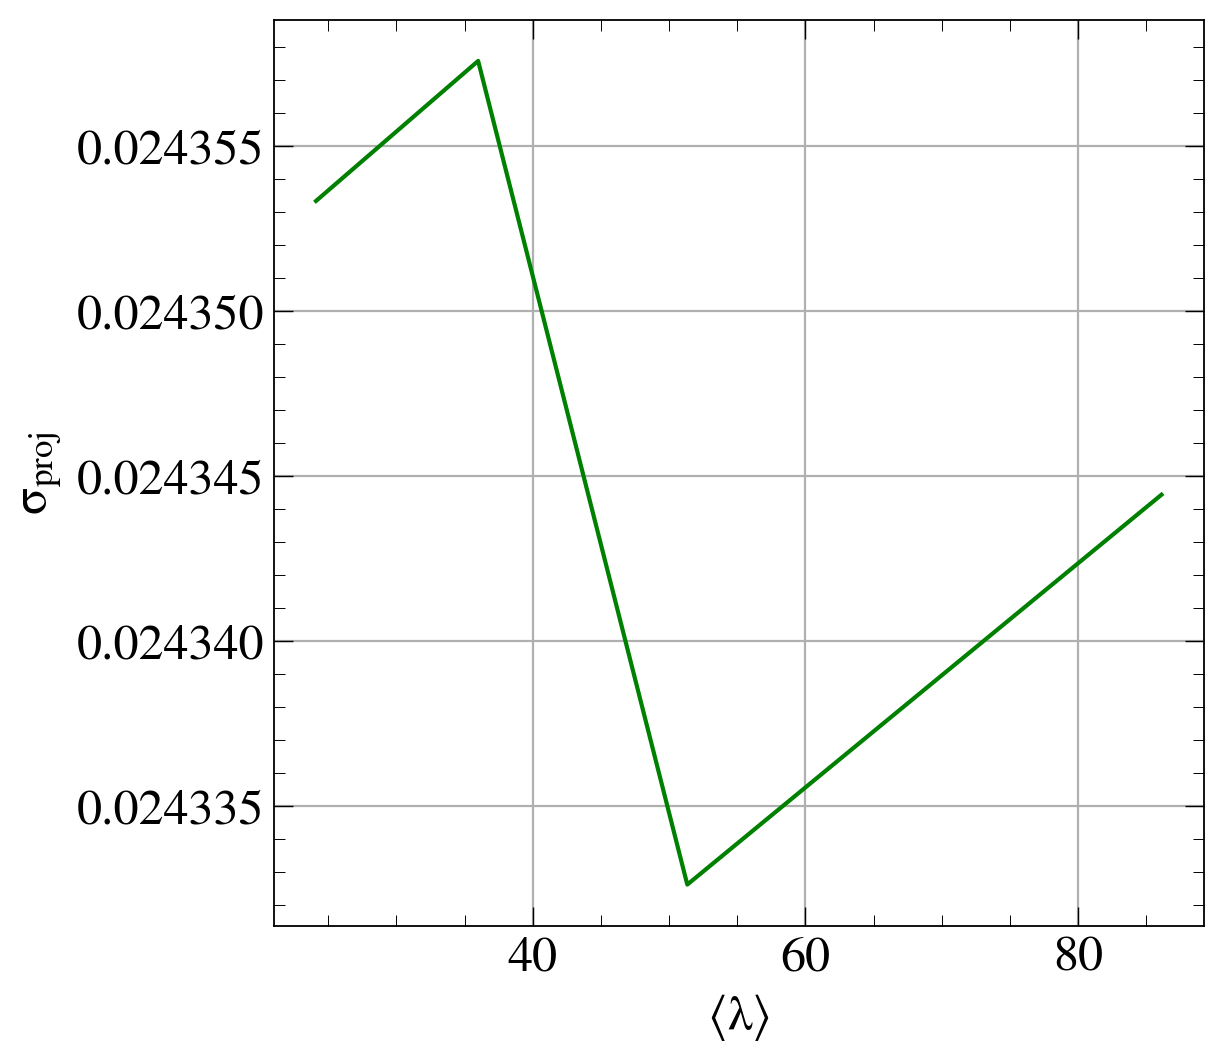

In [118]:
# plt.figure(figsize=(6,4), dpi=500)
# plt.plot(myles_mean_bin_richness, myles_sigma_cl, label='myles', color='orange')
plt.plot(mean_bin_richness, bf_sigma_proj, color='green')
plt.xlabel(r'$\rm \langle \lambda \rangle$')
plt.ylabel(r'$\rm \sigma_{proj}$')
plt.show()

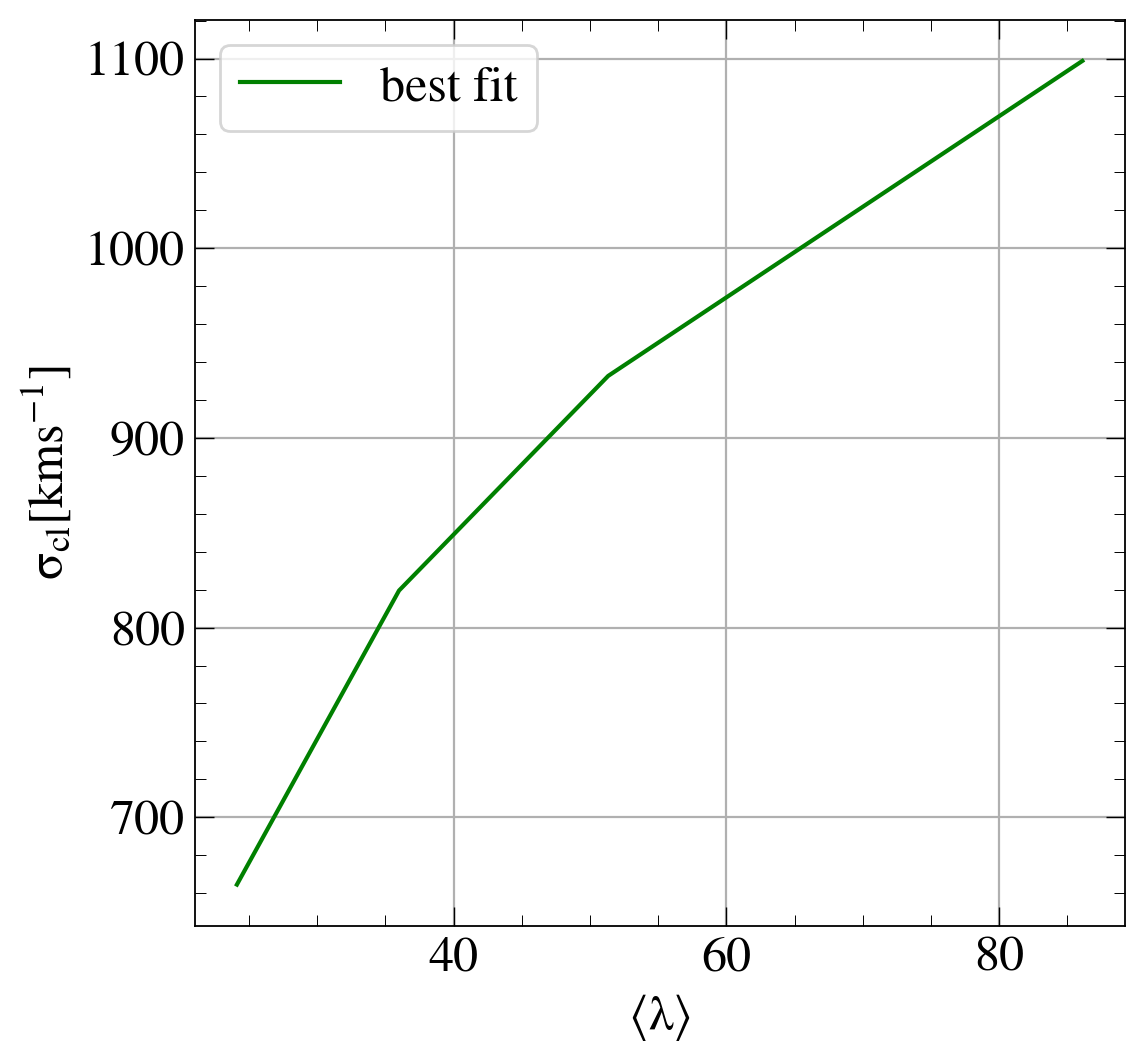

In [120]:
# plt.figure(figsize=(6,4), dpi=500)
# plt.plot(myles_mean_bin_richness, myles_sigma_cl, label='myles', color='orange')
plt.plot(mean_bin_richness, bf_sigma_cl*3e5, label='best fit', color='green')
plt.xlabel(r'$\rm \langle \lambda \rangle$')
plt.ylabel(r'$\rm \sigma_{cl} [km s^{-1}]$')
plt.legend()
plt.show()

In [99]:
redmapper_cl = redmapper_cl[(redmapper_cl['redshift']>=0.2) & (redmapper_cl['redshift']<=1)]
redmapper_me = redmapper_me[(redmapper_me['members/z']>=0.2) & (redmapper_me['members/z']<=1)]

In [100]:
redmapper_cl = redmapper_cl[(redmapper_cl['redshift']>=0.2) & (redmapper_cl['redshift']<=1)]
redmapper_me = redmapper_me[(redmapper_me['members/z']>=0.2) & (redmapper_me['members/z']<=1)]

zranges = [(0.2,0.35), (0.35, 0.5), (0.5, 0.65), (0.65, 0.8), (0.8,1)]
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]', '(0.65, 0.8]','(0.8,1]']
redmapper_cl['redshift_range'] = pd.cut(redmapper_cl['redshift'], bins=[r[0] for r in zranges] + [zranges[-1][-1]],
                                            labels=zlabels).astype(str)
redmapper_me['redshift_range'] = pd.cut(redmapper_me['members/z'], bins=[r[0] for r in zranges] + [zranges[-1][-1]],
                                            labels=zlabels).astype(str)